# Imports

In [22]:
import string
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# config

In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# load data

In [24]:
emotions_csv = pd.read_csv('NRC-Emotion-Lexicon-v0.92-English.csv', header=0)
emotions_csv.head()

,English,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0


# load emotions into memory while ranking them (prefer negative over positive)

In [25]:
all_emotions = {
    'Anger': (1, 'negative'), 
    'Fear': (2, 'negative'),  
    'Disgust': (3, 'negative'), 
    'Sadness': (4, 'negative'),  
    'Surprise': (5, 'negative'),  
    'Anticipation': (6, 'positive'),  
    'Joy': (7, 'positive'),   
    'Trust': (8, 'positive'), 
}

pos_emotions = {
    'Anticipation': (1, 'positive'),  
    'Joy': (2, 'positive'),   
    'Trust': (3, 'positive')
}

neg_emotions = {
    'Anger': (1, 'negative'), 
    'Fear': (2, 'negative'),  
    'Disgust': (3, 'negative'), 
    'Sadness': (4, 'negative'),  
    'Surprise': (5, 'negative'),  
}


def get_emotions_list(row):    
    if row.Positive and not row.Negative:
        return pos_emotions
    
    if not row.Positive and row.Negative:
        return neg_emotions
    
    return all_emotions

def get_emotion_data(row):
    context = None
    
    emotions = get_emotions_list(row)
    
    for col, val in row.iteritems():
        
        # check emotion columns with value == 1
        if col in emotions and val == 1:
            
            # first time
            if context is None:
                context = (col, emotions[col])
                
            # prefer low rank context over high ones (i.e. prefer negative over positive)
            else:
                if emotions[col][0] < emotions[context[0]][0]:
                    context = (col, emotions[col])
                    
    # return the emotion text
    if context is not None:
        return context[0], context[1][1]
    return 'other', 'other'

In [26]:
emotions_dict = {}
for index, row in emotions_csv.iterrows():
    # lemmatize
    word = WordNetLemmatizer().lemmatize(str(row.English))
    context, category = get_emotion_data(row)
    emotions_dict[word] = {
        'context': context,
        'category': category
    }

print(len(emotions_dict), 'word(s)')

13922 word(s)


# load stopwords

In [27]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# load tweets data

In [28]:
df = pd.read_csv('..\\tweets_sentiment.csv', header=0)

# analyse emotions
- clean text from punctuations
- remove stopwords
- return each word to its original form (lemmatization)
- `finally`, check text for any emotion reference word

In [29]:
def get_emotions(tweet):
    # clean string
    tweet = str(tweet)
    tweet = tweet.lower()
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # get words
    tokenized_words = word_tokenize(tweet, "english")

    # remove stopwords
    final_words = []
    for word in tokenized_words:
        if word not in stop_words:
            final_words.append(word)

    # lemmatize words
    lemma_words = []
    for word in final_words:
        word = WordNetLemmatizer().lemmatize(word)
        lemma_words.append(word)

    # check emotion
    emotion = ['other', 'other']
    for word in lemma_words:
        if word in emotions_dict:
            if emotions_dict[word]['context']:
                emotion = [emotions_dict[word]['context'], emotions_dict[word]['category']]
            break

    # return emotion data
    return pd.Series(emotion)

In [30]:
df[['emotion', 'emotion_category']] = df.translated_text.apply(get_emotions)

# check data

In [31]:
df[['translated_text', 'emotion', 'emotion_category']].head()

,translated_text,emotion,emotion_category
0,#Corona #COVIDー19 Official Numbers in Lebanon ...,other,other
1,# Corona_Lebanon\n#coronavirus,other,other
2,"The management of the ""Palma"" resort explains ...",Trust,positive
3,Urgent: The Lebanese Ministry of Health: 415 C...,Fear,negative
4,"Finally, the 7 of September gets rid of the ge...",Anticipation,positive


# functions to group data and visualize it

In [32]:
def group_emtions(df_):
    result = df_.groupby('emotion').count().reset_index()[['emotion', 'translated_text']]
    result = result.rename(columns={result.columns[1]: 'count_'})
    return result

def pie_plot(df_):
    fig1, ax1 = plt.subplots(figsize=(10, 7))
    ax1.pie(df_.count_.values.tolist(), labels=df_.emotion.values.tolist())
    ax1.axis('equal')
    plt.show()

# emotions and their tweet count

In [33]:
group_emtions(df)

,emotion,count_
0,Anger,2128
1,Anticipation,5504
2,Disgust,313
3,Fear,3538
4,Joy,1803
5,Sadness,738
6,Surprise,237
7,Trust,3142
8,other,33485


# positive emotions distribution

In [34]:
pos_data = group_emtions( df[ (df.sentiment_label2 == 'POSITIVE') ] ) # & (df.emotion_category == 'positive')
pos_data

,emotion,count_
0,Anger,634
1,Anticipation,2893
2,Disgust,129
3,Fear,1096
4,Joy,761
5,Sadness,221
6,Surprise,81
7,Trust,1472
8,other,15614


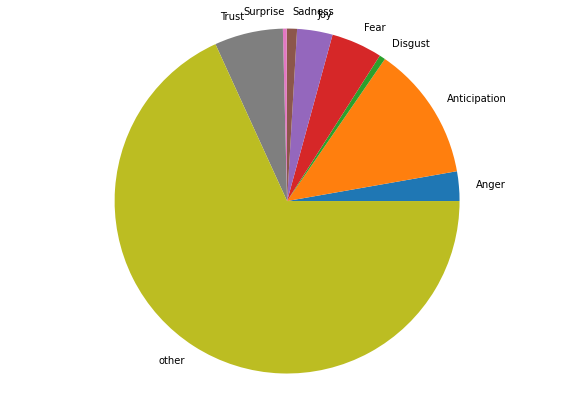

In [35]:
pie_plot(pos_data) 

# negative emotions distribution

In [36]:
neg_data = group_emtions( df[ (df.sentiment_label2 == 'NEGATIVE')  ] ) # & (df.emotion_category == 'negative')
neg_data

,emotion,count_
0,Anger,1494
1,Anticipation,2611
2,Disgust,184
3,Fear,2442
4,Joy,1042
5,Sadness,517
6,Surprise,156
7,Trust,1670
8,other,17871


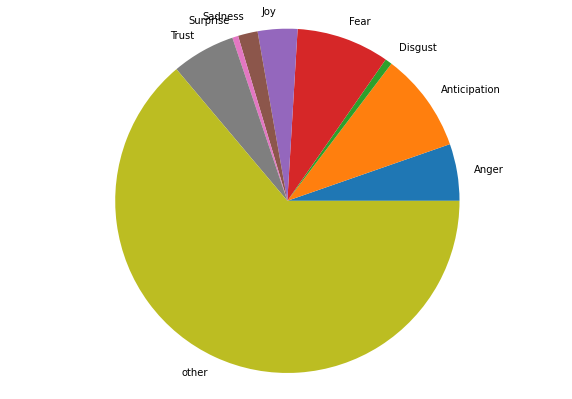

In [37]:
pie_plot(neg_data) 

In [44]:
data = df[ (df.sentiment_label2 == 'POSITIVE') & (df.emotion == 'Anger') ][['text', 'translated_text']]
for index, d in data.iterrows():
    print(d.text)
    print(d.translated_text)
    print('----------------------------------------------------------------------------------')

لا إصابات في شركة غولدن ستار
https://cutt.ly/fflJOgj
#كورونا #لبنان
No injuries at the Golden Star
https://cutt.ly/fflJOgj
# Corona # Lebanon
----------------------------------------------------------------------------------
غرفة إدارة الكوارث في #عكار: 12 إصابة جديدة بفيروس #كورونا
https://mulhak.com/p/28031761
#لبنان #ملحق
Disaster Management Room in Akkar: 12 new cases of Coronavirus
https://mulhak.com/p/28031761
#Lebanon # supplement
----------------------------------------------------------------------------------
امل حجازي تُصنف لبنان بعدة اوبئة https://beirutcom.net/189415 #BeirutcomMag via 
@BeirutcomMag
 

#امل_حجازي 
@AmalHijazi
 #لبنان #كورونا_لبنان #بيروت #بيروتكم #الزعماء_الوباء_القاتل
Amal Hijazi classifies Lebanon with several epidemics https://beirutcom.net/189415 #BeirutcomMag via
@BeirutcomMag
 

#Amal Hijazi
@America_My
 #Lebanon # Corona_Lebanon #Beirut #Leaders_the killing epidemic
----------------------------------------------------------------------------------
ل

I was depressed in Lebanon now I'm depressed but in Germany with good healthcare 24/7 electricity running water good transportation system etc..
I was depressed in Lebanon now I'm depressed but in Germany with good healthcare 24/7 electricity running water good transportation system etc..
----------------------------------------------------------------------------------
Personalized Cancer Therapy: A Source of Confidence for Patients via @SAPnews https://news.sap.com/2020/02/personalized-cancer-therapy-mh-guide-sap-hana/…#healthcare #cancer #therapy #personalizedcare #sap #lebanon
Personalized Cancer Therapy: A Source of Confidence for Patients via @SAPnews https://news.sap.com/2020/02/personalized-cancer-therapy-mh-guide-sap-hana/…#healthcare #cancer #therapy #personalizedcare #sap #lebanon
----------------------------------------------------------------------------------
Can you take on the challenge to live on the same rations as a Syrian refugee OR walk 40km? Your raised funds will